# Анализ данных об оптовых продажах аудиотехники

## Описание данных:

**В данном проекте представлена аналитика для компании «Карпов Саунд», которая занимается оптовой продажей аудиотехники и предлагает широкий ассортимент товаров от ведущих мировых брендов, включающий профессиональные аудиосистемы, домашние кинотеатры, портативные аудиоустройства и прочие аксессуары.** 

«Карпов Саунд» сотрудничает с крупными розничными сетями и специализированными магазинами аудиотехники в России. Клиенты компании регулярно оставляют заявки на закупку товаров в CRM системе, менеджеры связываются с клиентами, обсуждают детали, после чего заказы либо подтверждаются менеджерами, либо по разным причинам отменяются. 

В «Карпов Саунд» трепетно относятся к хранению информации о своих товарах, клиентах и заказах, однако в самый неподходящий момент хранилище данных компании оказалось временно недоступно из-за плановых работ по его оптимизации. Поэтому в рамках этого проекта все данные будут представлены не в самом удобном для анализа виде — в формате резервной выгрузки, разложенной по разным папкам на сервере компании.

Необходимо собрать данные из разрозненных источников, проанализировать их и сделать выводы, которые помогут руководству компании принять верные тактические решения.

**В данном проекте встретятся следующие таблицы:**  

1) orders (данные о заказах):  
- order_id — номер заказа  
- product_id — идентификатор товара  
- quantity — количество этого товара в заказе

2) order_status (данные о статусах заказов и клиентах):
- order_id — номер заказа  
- client_id — идентификатор клиента  
- status — статус заказа

3) products (данные о товарах):
- id — идентификатор товара  
- name — имя товара (сначала указан бренд, через запятую модель товара)  
- price — цена единицы товара, в долларах

Каждый заказ имеет статус или подтвержденного (`confirmed`), или отмененного (`canceled`). В одном заказе может быть несколько разных товаров. Если заказ был отменен, а потом создан такой же (тем же клиентом, с теми же товарами, у того же менеджера), в базе останется запись о двух заказах с разными номерами и статусами, поскольку система не позволяет создать заказ с тем же номером.

## Задачи:

1. Собрать и подготовить данные в удобном для анализа формате 
2. Провести аналитику продаж по дням - определить дни, которые выбиваются из общей картины, и выяснить причину 
3. Посчитать ключевые метрики в динамике
4. Найти наиболее прибыльные бренды и те, которые зря занимают место на виртуальной «полке»
5. Сделать отчет об эффективности менеджеров по продажам 

## 1. Предобработка данных

### Сначала соберем три датасета: `orders.csv`, `order_status.csv`, `products.csv`.

На схеме показано, как связаны таблицы между собой:

![](https://storage.yandexcloud.net/klms-public/production/learning-content/457/4167/37264/104636/497986/er_white.png)

Данные находятся в папке `data` из директории `shared` (`shared` -> `homeworks` -> `python_ds_miniprojects` -> `final_project`). Внутри папки `data` находятся 2 другие папки: `orders` и `products`.

В папке `orders` папки с датами, в которые сделаны записи. В этих папках — папки с именами менеджеров по продажам. Эти папки содержат файлы `orders.csv` и `order_status.csv` (в каждой папке по одной паре файлов). Пример структуры: `data` -> `orders` -> `2024-03-01` -> `Алексей Саксофонов` -> `orders.csv` и `order_status.csv`.

В папке `products` папки с категориями товаров. В этих папках файлы `products.csv` (в каждой папке по одному файлу). Пример структуры: `data` -> `products` -> `AV-процессор` -> `products.csv`.

Кроме того у вас есть файл `usd_rate.txt` с курсом доллара США на каждый день анализируемого периода (данные в формате `дата,курс,валюта`).

### Собераем данные со всех папок в три датафрейма

1. `df_orders` — на основе датасетов `orders.csv` + добавьте колонку `manager` с именами менеджеров и колонку `date` с датами. 
2. `df_order_status` — на основе датасетов `order_status.csv`.  
3. `df_products` — на основе датасетов `products.csv` + добавьте колонку `category` с категориями товаров.  

In [179]:
import os
import pandas as pd


In [180]:
p = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-alena-semechkova-p-96bf1/shared/homeworks/python_ds_miniprojects/final_project/data'

In [181]:
target_files = ['orders.csv', 'order_status.csv', 'products.csv']

In [182]:
for path, dirs, files in os.walk(p):
    print(path, dirs, files)

/mnt/HC_Volume_18315164/home-jupyter/jupyter-alena-semechkova-p-96bf1/shared/homeworks/python_ds_miniprojects/final_project/data ['products', 'orders'] []
/mnt/HC_Volume_18315164/home-jupyter/jupyter-alena-semechkova-p-96bf1/shared/homeworks/python_ds_miniprojects/final_project/data/products ['AV-ресивер', 'Настенная акустика', 'Система караоке', 'Напольная акустика', 'Полочная акустика', 'Сабвуфер', 'Саундбар', 'Активные колонки', 'Беспроводная акустика', 'Конденсаторный микрофон', 'Центральный канал', 'Динамический микрофон', 'AV-процессор', 'Предусилитель', 'Интегральный усилитель', 'Виниловый проигрыватель', 'Комплекты акустики', 'Наушники с микрофоном', 'Умная колонка', 'Домашний кинотеатр', 'Ламповый усилитель', 'Музыкальный центр', 'Портативная акустика', 'Проводные наушники', 'Усилитель мощности', 'Беспроводные наушники'] []
/mnt/HC_Volume_18315164/home-jupyter/jupyter-alena-semechkova-p-96bf1/shared/homeworks/python_ds_miniprojects/final_project/data/products/AV-ресивер [] ['p

In [183]:
orders_df_list = []
order_status_df_list = []
products_df_list = []  

for path, dirs, files in os.walk(p):
    for file in files:
        if file.endswith('orders.csv'):
            file_path = os.path.join(path, file)
            orders_df_list.append(file_path)
        elif file.endswith('order_status.csv'):
            file_path = os.path.join(path, file)
            order_status_df_list.append(file_path)
        elif file.endswith('products.csv'):
            file_path = os.path.join(path, file)
            products_df_list.append(file_path)

In [184]:
products_df_list

['/mnt/HC_Volume_18315164/home-jupyter/jupyter-alena-semechkova-p-96bf1/shared/homeworks/python_ds_miniprojects/final_project/data/products/AV-ресивер/products.csv',
 '/mnt/HC_Volume_18315164/home-jupyter/jupyter-alena-semechkova-p-96bf1/shared/homeworks/python_ds_miniprojects/final_project/data/products/Настенная акустика/products.csv',
 '/mnt/HC_Volume_18315164/home-jupyter/jupyter-alena-semechkova-p-96bf1/shared/homeworks/python_ds_miniprojects/final_project/data/products/Система караоке/products.csv',
 '/mnt/HC_Volume_18315164/home-jupyter/jupyter-alena-semechkova-p-96bf1/shared/homeworks/python_ds_miniprojects/final_project/data/products/Напольная акустика/products.csv',
 '/mnt/HC_Volume_18315164/home-jupyter/jupyter-alena-semechkova-p-96bf1/shared/homeworks/python_ds_miniprojects/final_project/data/products/Полочная акустика/products.csv',
 '/mnt/HC_Volume_18315164/home-jupyter/jupyter-alena-semechkova-p-96bf1/shared/homeworks/python_ds_miniprojects/final_project/data/products/Са

In [185]:
df_orders = pd.DataFrame()
df_order_status = pd.DataFrame()
df_products = pd.DataFrame() 

In [186]:
for i in orders_df_list:
    data = pd.read_csv(i)
    data['manager'] = i.split('/')[-2]
    data['date'] = i.split('/')[-3]
    df_orders = pd.concat([df_orders, data], ignore_index=True)

In [187]:
df_orders.head()

,order_id,product_id,quantity,manager,date
0,QPLK-54839036,489,11,Владимир Ударников,2024-03-10
1,QPLK-54839036,594,6,Владимир Ударников,2024-03-10
2,QPLK-54839036,670,16,Владимир Ударников,2024-03-10
3,QPLK-54839036,469,9,Владимир Ударников,2024-03-10
4,QPLK-54839036,1302,5,Владимир Ударников,2024-03-10


In [188]:
for i in order_status_df_list:
    data = pd.read_csv(i)
    df_order_status = pd.concat([df_order_status, data], ignore_index=True)

In [189]:
df_order_status.head()

,order_id,client_id,status
0,QPLK-54839036,52,confirmed
1,MAQJ-95867467,84,canceled
2,KHLF-51759445,23,confirmed
3,DALF-47566548,97,confirmed
4,BZHU-92977894,29,canceled


In [190]:
for i in products_df_list:
    data = pd.read_csv(i)
    data['category'] = i.split('/')[-2]
    df_products = pd.concat([df_products, data], ignore_index=True)

In [191]:
df_products.head()

,id,name,price,category
0,207,"Denon, AVR-S540BT",243.52,AV-ресивер
1,208,"Denon, AVR-X3700H",1305.52,AV-ресивер
2,209,"Denon, AVR-X4700H",1620.21,AV-ресивер
3,210,"Denon, AVR-X6700H",2050.31,AV-ресивер
4,211,"Denon, AVC-X4700H",1496.81,AV-ресивер


In [192]:
df_orders.to_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-alena-semechkova-p-96bf1/lesson_9/df_orders.csv', index=False)

In [193]:
df_order_status.to_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-alena-semechkova-p-96bf1/lesson_9/df_order_status.csv', index=False)

In [194]:
df_products.to_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-alena-semechkova-p-96bf1/lesson_9/df_products.csv', index=False)

## 2.1 Посмотрим на общую динамику заказов 
**и определим есть ли дни, которые выбиваются из общей картины**

In [195]:
order_by_day = df_orders.groupby('date').agg({'order_id': 'count'}).sort_values('order_id', ascending = False)\
    .reset_index()\
    .astype({'date': 'datetime64'})

In [196]:
order_by_day['day_name'] = order_by_day.date.dt.day_name()

In [197]:
order_by_day = order_by_day.sort_values('day_name') 
## Сортируем по дням недели, чтобы на графике была заметна зависимость от дня недели

In [198]:
order_by_day.head()

,date,order_id,day_name
30,2024-03-08,5,Friday
2,2024-03-01,302,Friday
3,2024-03-29,241,Friday
5,2024-03-15,225,Friday
12,2024-03-22,191,Friday


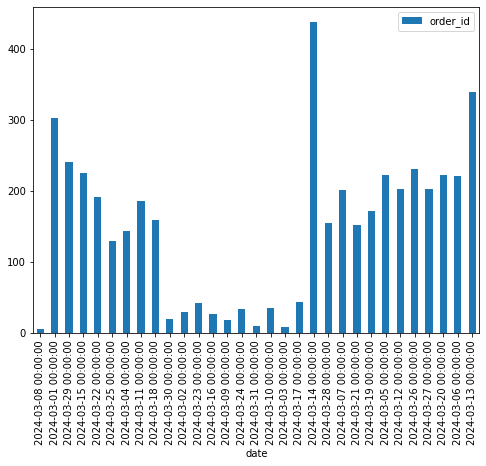

In [199]:
order_by_day.plot.bar(figsize=(8, 6),
                      x= 'date', 
                      xlabel='date'
                     )

### Результаты:
1. День с наибольшим количеством заказов: **2024-03-14** 
2. Также заметен день, который выбивается из общей картины: **2024-03-08**. Это будний день с очень маленьким количеством заказов, думаю, это можно объяснить тем, что 03.08 - это праздничный день, поэтому не будем его учитывать в анализе зависимости заказов от дня недели 

## 2.2 Построим график с количеством заказов по дням 
**и определим, заметна ли в данных сезонность**

In [200]:
import seaborn as sns 
import matplotlib.pyplot as plt

In [201]:
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

[Text(0, 0, 'Маргарита Камертонова'),
 Text(1, 0, 'Виктор Тромбонов'),
 Text(2, 0, 'Максим Барабанов'),
 Text(3, 0, 'Владимир Ударников'),
 Text(4, 0, 'Алексей Саксофонов'),
 Text(5, 0, 'Ксения Балалайкина'),
 Text(6, 0, 'Екатерина Тарелкина'),
 Text(7, 0, 'Надежда Гармошкина'),
 Text(8, 0, 'Анастасия Дудкина'),
 Text(9, 0, 'Антон Скрипкин'),
 Text(10, 0, 'Аркадий Октавин'),
 Text(11, 0, 'Сергей Контрабасов')]

[Text(0, 0, 'Friday'),
 Text(0, 0, 'Monday'),
 Text(0, 0, 'Saturday'),
 Text(0, 0, 'Sunday'),
 Text(0, 0, 'Thursday'),
 Text(0, 0, 'Tuesday'),
 Text(0, 0, 'Wednesday')]

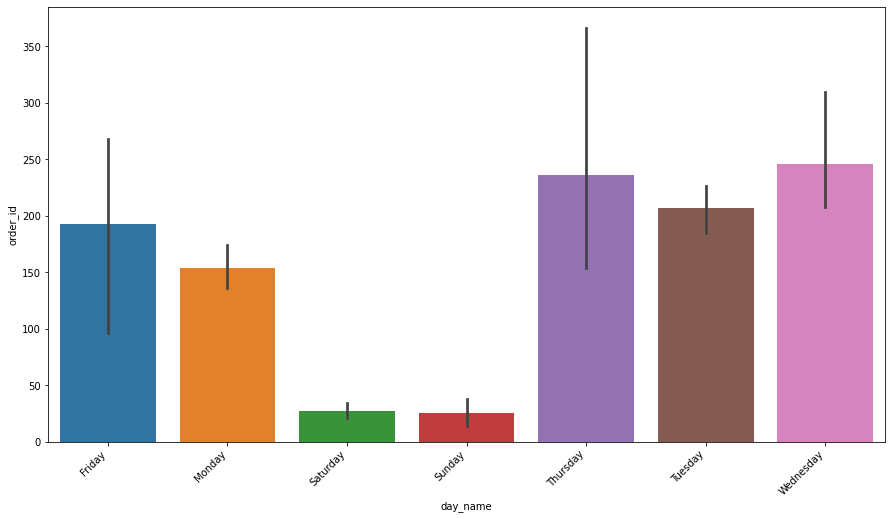

In [202]:
fig, ax = plt.subplots(figsize=(15, 8))
ax = sns.barplot(data = order_by_day, x = 'day_name', y = 'order_id') 
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

### Можем заметить зависимость количества заказов от дня недели: в выходные дни заказов меньше, чем в будни

## 2.3 Проанализируем причины всплеска 2024-03-14

Добавим к данным информацию о статусах заказов и посмотрим на соотношение отмененных и подтвержденных заказов, особенно в интересующий нас день 2024-03-14.

In [203]:
orders_status = df_orders.merge(df_order_status, how='inner', on='order_id')



In [204]:
orders_status.to_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-alena-semechkova-p-96bf1/lesson_9/orders_status.csv', index=False)

### Посчитаем долю подтвержденных и отмененных заказов за все наблюдения:

In [205]:
status = orders_status.groupby('status').agg({'order_id': 'count'}) 


In [206]:
status

,order_id
status,
canceled,520
confirmed,4083


In [207]:
all = status.order_id.sum()
print(f"Все заказы - {all}")

Все заказы - 4603


In [208]:
status['part'] = (status.order_id / all).round(2)

In [209]:
status

,order_id,part
status,,
canceled,520,0.11
confirmed,4083,0.89


### Теперь посчитаем для каждой даты отдельно:

**Посчитайте количество подтвержденных и отмененных заказов на каждую дату.** Определите, в какой день не было ни одного подтвержденного заказа. Для этого сделайте сводную таблицу, где в строках будут даты, в колонках — стутасы заказов, а значения — число заказов с этим статусом в определенную дату. Пропуски заполните нулями.  

**В ответ укажите день, когда не было ни одного подтвержденного заказа.** Дату укажите в том формате, в котором она представлена в данных (гггг-мм-дд).

In [210]:
orders_status = orders_status.groupby(['date', 'status']).agg({'order_id': 'count'}, as_idex=False).reset_index()

In [211]:
orders_status = orders_status.rename(columns = {'order_id': 'orders_count'}) 

In [212]:
# таблица, с количеством подтвержденных и отмененных заказов. 
# Если заказов в этот день не было, то строчка за эту дату будет отстуствовать
orders_status 

,date,status,orders_count
0,2024-03-01,canceled,29
1,2024-03-01,confirmed,273
2,2024-03-02,confirmed,30
3,2024-03-03,confirmed,8
4,2024-03-04,confirmed,143
5,2024-03-05,confirmed,222
6,2024-03-06,canceled,12
7,2024-03-06,confirmed,209
8,2024-03-07,canceled,5
9,2024-03-07,confirmed,196


In [213]:
orders_status_new = orders_status.pivot(index='date', columns='status', values='orders_count').reset_index().fillna(0)

In [214]:
orders_status_new # Перевернули таблицу таким образом, чтобы все данные были представлены без пропусков

status,date,canceled,confirmed
0,2024-03-01,29.0,273.0
1,2024-03-02,0.0,30.0
2,2024-03-03,0.0,8.0
3,2024-03-04,0.0,143.0
4,2024-03-05,0.0,222.0
5,2024-03-06,12.0,209.0
6,2024-03-07,5.0,196.0
7,2024-03-08,0.0,5.0
8,2024-03-09,18.0,0.0
9,2024-03-10,12.0,23.0


### Можем заметить, что перед днем с наибольшим количеством заказов, было много отмен.
Построим линейный график, чтобы наглядно продемонстрировать динамику подтверждений и отказов.

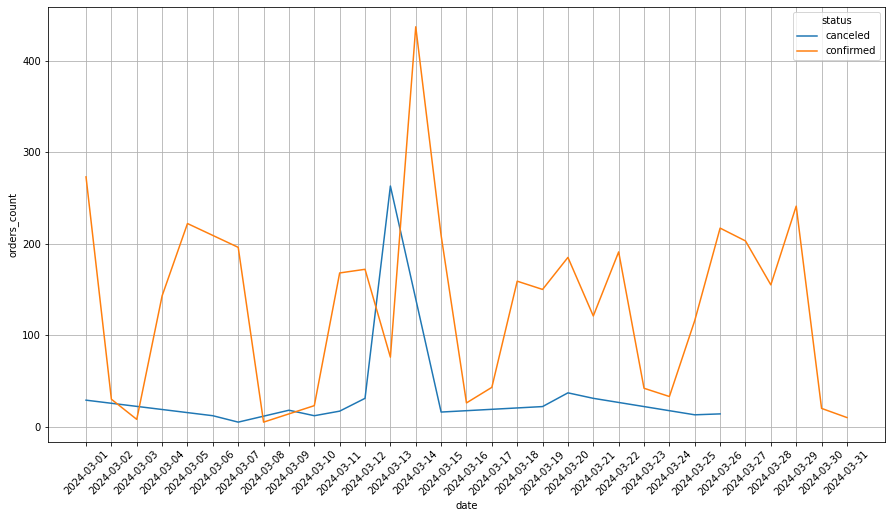

In [215]:
fig, ax = plt.subplots(figsize=(15, 8))
ax = sns.lineplot(data=orders_status, x='date', y='orders_count', hue='status');
plt.grid() 
plt.xticks(rotation=45)
plt.show()

### Рассмотрим отдельно день с наибольшим числом заказов, который мы определили ранее, и день, предшествующий ему. Выявим причины.
Проверим не повторяются ли отмененные заказы 2024-03-13 с подтвержденными 2024-03-14. сли заказ один и тот же, у него будут совпадать параметры: клиент, менеджер, количество уникальных товаров в заказе и общее число товаров в штуках, но номера заказов будут разными.

In [216]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-alena-semechkova-p-96bf1/lesson_9/orders_status.csv')

df.head()

,order_id,product_id,quantity,manager,date,client_id,status
0,QPLK-54839036,489,11,Владимир Ударников,2024-03-10,52,confirmed
1,QPLK-54839036,594,6,Владимир Ударников,2024-03-10,52,confirmed
2,QPLK-54839036,670,16,Владимир Ударников,2024-03-10,52,confirmed
3,QPLK-54839036,469,9,Владимир Ударников,2024-03-10,52,confirmed
4,QPLK-54839036,1302,5,Владимир Ударников,2024-03-10,52,confirmed


In [217]:
df.query('date=="2024-03-13" or date=="2024-03-14"') 

,order_id,product_id,quantity,manager,date,client_id,status
1604,IMND-92004620,1634,20,Владимир Ударников,2024-03-14,38,confirmed
1605,IMND-92004620,259,9,Владимир Ударников,2024-03-14,38,confirmed
1606,IMND-92004620,812,24,Владимир Ударников,2024-03-14,38,confirmed
1607,IMND-92004620,652,10,Владимир Ударников,2024-03-14,38,confirmed
1608,IMND-92004620,516,8,Владимир Ударников,2024-03-14,38,confirmed
...,...,...,...,...,...,...,...
3520,BBFJ-27674101,447,18,Ксения Балалайкина,2024-03-13,73,canceled
3521,GHGB-88045656,898,10,Ксения Балалайкина,2024-03-13,7,canceled
3522,GHGB-88045656,1401,12,Ксения Балалайкина,2024-03-13,7,canceled
3523,GHGB-88045656,658,12,Ксения Балалайкина,2024-03-13,7,canceled


In [218]:
df_14 = df.query('date=="2024-03-14"')

In [219]:
df_14.head()

,order_id,product_id,quantity,manager,date,client_id,status
1604,IMND-92004620,1634,20,Владимир Ударников,2024-03-14,38,confirmed
1605,IMND-92004620,259,9,Владимир Ударников,2024-03-14,38,confirmed
1606,IMND-92004620,812,24,Владимир Ударников,2024-03-14,38,confirmed
1607,IMND-92004620,652,10,Владимир Ударников,2024-03-14,38,confirmed
1608,IMND-92004620,516,8,Владимир Ударников,2024-03-14,38,confirmed


In [220]:
df_13 = df.query('date=="2024-03-13"')
df_13.head()

,order_id,product_id,quantity,manager,date,client_id,status
3186,NENO-68279828,1634,20,Владимир Ударников,2024-03-13,38,canceled
3187,NENO-68279828,259,9,Владимир Ударников,2024-03-13,38,canceled
3188,NENO-68279828,812,24,Владимир Ударников,2024-03-13,38,canceled
3189,NENO-68279828,652,10,Владимир Ударников,2024-03-13,38,canceled
3190,NENO-68279828,516,8,Владимир Ударников,2024-03-13,38,canceled


In [221]:
df_13.merge(df_14, how='outer', on=['client_id', 'manager', 'product_id', 'quantity']) 
# Соединяем датафреймы по тем параметрам, которые должы совпасть. Все строки получившейся таблицы - это повторяющиеся заказы.

,order_id_x,product_id,quantity,manager,date_x,client_id,status_x,order_id_y,date_y,status_y
0,NENO-68279828,1634,20,Владимир Ударников,2024-03-13,38,canceled,IMND-92004620,2024-03-14,confirmed
1,NENO-68279828,259,9,Владимир Ударников,2024-03-13,38,canceled,IMND-92004620,2024-03-14,confirmed
2,NENO-68279828,812,24,Владимир Ударников,2024-03-13,38,canceled,IMND-92004620,2024-03-14,confirmed
3,NENO-68279828,652,10,Владимир Ударников,2024-03-13,38,canceled,IMND-92004620,2024-03-14,confirmed
4,NENO-68279828,516,8,Владимир Ударников,2024-03-13,38,canceled,IMND-92004620,2024-03-14,confirmed
...,...,...,...,...,...,...,...,...,...,...
548,NaN,1667,44,Ксения Балалайкина,NaN,67,NaN,JDDH-90010417,2024-03-14,confirmed
549,NaN,1607,4,Ксения Балалайкина,NaN,67,NaN,JDDH-90010417,2024-03-14,confirmed
550,NaN,644,34,Ксения Балалайкина,NaN,67,NaN,JDDH-90010417,2024-03-14,confirmed
551,NaN,65,15,Ксения Балалайкина,NaN,67,NaN,JDDH-90010417,2024-03-14,confirmed


### Можем сделать вывод, что в CRM системе произошел сбой, и отмененные заказы 2014-03-13 перенеслись на следующий день 2014-03-14

## 3. Посчитаем ключевые метрики, посмотрим на их динамику и составим небольшой отчет

Для расчта метрик нам потребуется расчитать среднее значение курса доллара за месяц, тк закупки товаров происходили в долларах, а продажи в рублях.

In [222]:
currency_rate = open('usd_rate.txt')


In [223]:
currency_rate = currency_rate.readlines()

In [224]:
currency_rate = pd.DataFrame(currency_rate, columns=['full'])
currency_rate.head()

,full
0,"2024-03-01,90.8423,Доллар США\n"
1,"2024-03-02,91.3336,Доллар США\n"
2,"2024-03-03,91.3336,Доллар США\n"
3,"2024-03-04,91.3336,Доллар США\n"
4,"2024-03-05,91.3534,Доллар США\n"


In [225]:
currency_rate['date'] = currency_rate['full'].str.split(',').str[0]
currency_rate['currency_rate'] = currency_rate['full'].str.split(',').str[1] 

In [226]:
currency_rate = currency_rate.drop(columns = ['full']) 
currency_rate.head()

,date,currency_rate
0,2024-03-01,90.8423
1,2024-03-02,91.3336
2,2024-03-03,91.3336
3,2024-03-04,91.3336
4,2024-03-05,91.3534


In [227]:
currency_rate = currency_rate.astype({'date': 'datetime64', 'currency_rate': 'float'}) 
# Переводим колонку date в удобный для работы тип datetime64

### 3.1 Расчет общей выручки:

In [228]:
orders_status = pd.read_csv('orders_status.csv')

In [229]:
orders_status = orders_status.astype({'date': 'datetime64'}) 

In [230]:
df_full = orders_status.merge(df_products, how='inner', left_on='product_id', right_on='id')

In [231]:
df_full = df_full.merge(currency_rate, how='inner', on='date')

In [232]:
df_full['cost_doll'] = df_full.quantity * df_full.price
df_full['cost_rub'] = df_full.cost_doll * df_full.currency_rate

In [233]:
df_full.head()

,order_id,product_id,quantity,manager,date,client_id,status,id,name,price,category,currency_rate,cost_doll,cost_rub
0,QPLK-54839036,489,11,Владимир Ударников,2024-03-10,52,confirmed,489,"Heco, Ambient 33F",290.74,Настенная акустика,90.7493,3198.14,2.902290e+05
1,QPLK-54839036,594,6,Владимир Ударников,2024-03-10,52,confirmed,594,"JBL, Control 28-1",301.85,Настенная акустика,90.7493,1811.10,1.643561e+05
2,QPLK-54839036,670,16,Владимир Ударников,2024-03-10,52,confirmed,670,"KEF, LSX Wireless",810.17,Беспроводная акустика,90.7493,12962.72,1.176358e+06
3,QPLK-54839036,469,9,Владимир Ударников,2024-03-10,52,confirmed,469,"Heco, Studio Pro 10",82.34,Конденсаторный микрофон,90.7493,741.06,6.725068e+04
4,QPLK-54839036,1302,5,Владимир Ударников,2024-03-10,52,confirmed,1302,"Rode, NT1-A",191.86,Конденсаторный микрофон,90.7493,959.30,8.705580e+04


In [234]:
df_success = df_full.query('status == "confirmed"')

In [235]:
revenue = round((df_success.cost_rub.sum()), 2)
print(f'Общая выручка = {revenue}')

Общая выручка = 2038231821.56


### 3.2 Средний чек:

In [236]:
average_bill = round((2038231821.564864 / 309), 2)
print(f'Средний чек = {average_bill}')

Средний чек = 6596219.49


### 3.3 Посмотрим на динамику этих метрик внутри месяца по дням

In [237]:
orders_by_day = df_full.groupby(['date', 'order_id'], as_index=False)  \
    .agg({'product_id': 'count', 'cost_rub': 'sum'}) 

orders_by_day = orders_by_day.drop(columns = ['product_id'])

In [238]:
orders_by_day.head()

,date,order_id,cost_rub
0,2024-03-01,AWYQ-42527250,5.945688e+06
1,2024-03-01,BWJC-51197045,3.742466e+06
2,2024-03-01,BXYD-83177339,3.346265e+06
3,2024-03-01,BZHU-92977894,1.016148e+07
4,2024-03-01,CGLU-02678560,2.207839e+06


In [239]:
all_orders_by_day = orders_by_day.groupby('date').agg({'order_id': 'count', 'cost_rub': 'sum'})
# Считаем количчество заказов и сумму на каждый день 

In [240]:
all_orders_by_day = all_orders_by_day.rename(columns = {'order_id': 'all_orders'}) 

In [241]:
all_orders_by_day.head()

,all_orders,cost_rub
date,,
2024-03-01,22,1.677811e+08
2024-03-02,2,1.197167e+07
2024-03-03,1,2.548418e+06
2024-03-04,10,6.404993e+07
2024-03-05,18,8.952724e+07


In [242]:
# Оставляем только успешные заказы
df_success = df_full.query('status == "confirmed"')

In [243]:
# Считаем количество успешных заказов на каждый день
success_orders_by_day = df_success.groupby(['date', 'order_id'], as_index=False)  \
    .agg({'product_id': 'count', 'cost_rub': 'sum'}) 

success_orders_by_day = success_orders_by_day.drop(columns = ['product_id'])

In [244]:
# Групируем по дате
success_orders_by_day = success_orders_by_day.groupby('date').agg({'order_id': 'count'})

In [245]:
success_orders_by_day = success_orders_by_day.rename(columns={'order_id': 'success_orders'})

In [246]:
# Объединяем с таблицей, где посчитали количество всез заказов и сумму продаж
orders_by_day = success_orders_by_day.merge(all_orders_by_day, how='inner', on='date')

In [247]:
# Расчитываем выручку в каждый день
orders_by_day = orders_by_day.rename(columns={'cost_rub': 'revenue_by_day'})

In [248]:
# Расчитываем средний чек в каждый день
orders_by_day['average_bill'] = (orders_by_day.revenue_by_day / orders_by_day.success_orders).round(2)

In [249]:
# Собираем таблицу с данными по количсетву успешных заказов
orders_count_by_day = orders_by_day.drop(columns = ['revenue_by_day', 'average_bill'])

In [250]:
orders_by_day = orders_by_day.drop(columns = ['success_orders', 'all_orders'])

In [251]:
orders_count_by_day.head()

,success_orders,all_orders
date,,
2024-03-01,20,22
2024-03-02,2,2
2024-03-03,1,1
2024-03-04,10,10
2024-03-05,18,18


In [252]:
import plotly.express as px

In [253]:
# Строим график с количеством успешных заказов
px.line(orders_count_by_day)

In [254]:
# Строим график с динамикой выручки и среднего чека
px.line(orders_by_day)

### Что можем заметить:
1. число заказов и выручка не каждый день изменяются в одинаковом направлении (если в какой-то день число заказов выросло, то выручка может упасть, и наоборот: число заказов упало — в этот же день выручка выросла)
2. средний чек и выручка не каждый день изменяются в одинаковом направлении (если в какой-то день средний чек вырос, то выручка может упасть, и наоборот: средний чек упал — в этот же день выручка выросла)
3. в день с наибольшим числом заказов выручка и/или средний чек не показывают максимальное значение
4. с течением времени выручка то увеличивается, то уменьшается
5. на протяжении всего месяца средний чек то увеличивается, то уменьшается

### Вывод:
В целом, у динамики продаж и размера среднего чека нет устойчивого роста или падения.

## 4. Проанализируем интерес клиентов к брендам

In [255]:
df_full['brand'] = df_full['name'].str.split(',').str[0]
df_full.head()

,order_id,product_id,quantity,manager,date,client_id,status,id,name,price,category,currency_rate,cost_doll,cost_rub,brand
0,QPLK-54839036,489,11,Владимир Ударников,2024-03-10,52,confirmed,489,"Heco, Ambient 33F",290.74,Настенная акустика,90.7493,3198.14,2.902290e+05,Heco
1,QPLK-54839036,594,6,Владимир Ударников,2024-03-10,52,confirmed,594,"JBL, Control 28-1",301.85,Настенная акустика,90.7493,1811.10,1.643561e+05,JBL
2,QPLK-54839036,670,16,Владимир Ударников,2024-03-10,52,confirmed,670,"KEF, LSX Wireless",810.17,Беспроводная акустика,90.7493,12962.72,1.176358e+06,KEF
3,QPLK-54839036,469,9,Владимир Ударников,2024-03-10,52,confirmed,469,"Heco, Studio Pro 10",82.34,Конденсаторный микрофон,90.7493,741.06,6.725068e+04,Heco
4,QPLK-54839036,1302,5,Владимир Ударников,2024-03-10,52,confirmed,1302,"Rode, NT1-A",191.86,Конденсаторный микрофон,90.7493,959.30,8.705580e+04,Rode


### 4.1 Найдем бренды с наибольшей выручкой:

In [256]:
revenue_by_brand = df_full.groupby('brand').agg({'cost_rub': 'sum'})

In [257]:
revenue_by_brand.cost_rub.round(1) \
    .sort_values(ascending=False)

brand
JBL            308011218.7
Heco           263204590.2
Klipsch        220510731.6
Yamaha         179867289.2
KEF            161983470.5
                  ...     
SMSL               38418.0
AudioSource        33881.7
Fosi Audio         31294.2
Bravo Audio        24050.9
Creative           10014.2
Name: cost_rub, Length: 121, dtype: float64

#### Бренд с наибольшей выручкой: JBL

In [258]:
df_full.groupby('brand').agg({'order_id': 'count'})\
    .sort_values(by='order_id', ascending=False)\
    .head()


,order_id
brand,
JBL,683
Heco,494
Yamaha,431
Klipsch,352
Magnat,231


#### Бренд с наибольшим количеством заказов: JBL

### 4.2 Определим бренды, которые представлены широким ассортиментом, но редко попадают в заказы

У одних брендов большинство товаров востребовано клиентами, а у других — клиенты заказывают только небольшую часть товаров, а остальные зря занимают виртуальную «полку» в перечне товаров, продаваемых вашей компанией. **Вам нужно определить, какие бренды редко попадают в заказы, хотя товаров таких брендов на самом деле много.**

Начнем с того, что определим, какие товары из имеющихся в продаже хоть раз заказывали, а какие — нет. Для этого соберите список из перечня уникальных идентификаторов товаров, которые встречаются в датафрейме `df_confirmed`. После этого для каждого товара в датафрейме `df_products` определите, был ли этот товар в списке заказанных товаров в этом месяце или нет: создайте новую колонку `is_in_orders` и заполните её соответственно значениями `yes` или `no` для каждого товара.

**В ответе укажите, сколько товаров были заказаны, а сколько — не были**

<details>
<summary>&#9658; Нажмите сюда, чтобы увидеть подсказку</summary>
  <p>
      
1) Сохраните в список `products_in_orders` уникальные идентификаторы товаров из датафрейма `df_confirmed`.
      
2) Создайте в датафрейме `df_products` новую колонку `is_in_orders`, в которой будет значение `yes`, если значение из колонки `id` этого датафрейма есть в списке `products_in_orders`. Если его в этом списке нет - в новую колонку для этой строчки запишите значение `no`.
      
3) Посчитайте количество встречающихся значений `yes` и  `no` в колонке `is_in_orders`.
      
</p>
</details>

In [259]:
# Оставляем только те товары, которые были заказаны
df_confirmed = df_full.query('status == "confirmed"')
df_confirmed.head()

,order_id,product_id,quantity,manager,date,client_id,status,id,name,price,category,currency_rate,cost_doll,cost_rub,brand
0,QPLK-54839036,489,11,Владимир Ударников,2024-03-10,52,confirmed,489,"Heco, Ambient 33F",290.74,Настенная акустика,90.7493,3198.14,2.902290e+05,Heco
1,QPLK-54839036,594,6,Владимир Ударников,2024-03-10,52,confirmed,594,"JBL, Control 28-1",301.85,Настенная акустика,90.7493,1811.10,1.643561e+05,JBL
2,QPLK-54839036,670,16,Владимир Ударников,2024-03-10,52,confirmed,670,"KEF, LSX Wireless",810.17,Беспроводная акустика,90.7493,12962.72,1.176358e+06,KEF
3,QPLK-54839036,469,9,Владимир Ударников,2024-03-10,52,confirmed,469,"Heco, Studio Pro 10",82.34,Конденсаторный микрофон,90.7493,741.06,6.725068e+04,Heco
4,QPLK-54839036,1302,5,Владимир Ударников,2024-03-10,52,confirmed,1302,"Rode, NT1-A",191.86,Конденсаторный микрофон,90.7493,959.30,8.705580e+04,Rode


In [260]:
product_in_orders = df_confirmed.groupby('product_id', as_index=False).agg({'order_id': 'count'})

In [261]:
product_in_orders.drop(columns=['order_id'])
product_in_orders.head()

,product_id,order_id
0,2,4
1,4,1
2,9,3
3,10,4
4,11,8


In [262]:
# Добавляем флаг о том, что товар был заказан хотя бы раз
product_in_orders['in_orders'] = 'yes'

In [263]:
product_in_orders.head()

,product_id,order_id,in_orders
0,2,4,yes
1,4,1,yes
2,9,3,yes
3,10,4,yes
4,11,8,yes


In [264]:
# Соединяем с таблицей, где есть все товары
product_in_orders_full = df_products.merge(product_in_orders, how='left', left_on='id', right_on='product_id')

In [265]:
# Вместо пропусков ставим флаг - нет (товар ни разу не был заказан)
product_in_orders_full = product_in_orders_full.fillna('no')

In [266]:
# Считаем количество заказанных и не заказанных товаров 
product_in_orders_full.groupby('in_orders').agg({'id': 'count'})

,id
in_orders,
no,497
yes,1180


In [267]:
product_in_orders_full.head()

,id,name,price,category,product_id,order_id,in_orders
0,207,"Denon, AVR-S540BT",243.52,AV-ресивер,207,2,yes
1,208,"Denon, AVR-X3700H",1305.52,AV-ресивер,208,3,yes
2,209,"Denon, AVR-X4700H",1620.21,AV-ресивер,209,1,yes
3,210,"Denon, AVR-X6700H",2050.31,AV-ресивер,210,2,yes
4,211,"Denon, AVC-X4700H",1496.81,AV-ресивер,211,4,yes


In [268]:
# Добавляем колонку с информацией о бренде
product_in_orders_full['brand'] = product_in_orders_full['name'].str.split(',').str[0]

In [269]:
product_in_orders_full.head()

,id,name,price,category,product_id,order_id,in_orders,brand
0,207,"Denon, AVR-S540BT",243.52,AV-ресивер,207,2,yes,Denon
1,208,"Denon, AVR-X3700H",1305.52,AV-ресивер,208,3,yes,Denon
2,209,"Denon, AVR-X4700H",1620.21,AV-ресивер,209,1,yes,Denon
3,210,"Denon, AVR-X6700H",2050.31,AV-ресивер,210,2,yes,Denon
4,211,"Denon, AVC-X4700H",1496.81,AV-ресивер,211,4,yes,Denon


In [270]:
# Считаем сколькими позициями представлен каждый бренд
count_products = product_in_orders_full.groupby('brand', as_index=False).agg({'id': 'count'})

In [271]:
# Фильтруем те бренды, у которых более 15 позиций 
big_brand = count_products.query('id > 15') 

In [272]:
big_brand.head()

,brand,id
17,Bose,21
32,Dali,67
36,Denon,41
39,Edifier,73
53,Harman Kardon,80


#### Посчитаем количество заказанных и не заказанных ни разу позиций у крупных брендов

In [273]:
big_brand_list = big_brand['brand']

In [274]:
big_brand_part = product_in_orders_full.query('brand in @big_brand_list') \
    .groupby(['brand', 'in_orders']).agg({'id': 'count'})

In [275]:
big_brand_part = big_brand_part.reset_index().pivot(index='brand', columns='in_orders', values='id')

In [276]:
# Считаем какую часть товаров от всего ассортимента бренда ни разу не покупали 
big_brand_part['part'] = ((big_brand_part.no / (big_brand_part.no + big_brand_part.yes)) * 100).round(2)

In [277]:
# Выводим сверху самые плохопродаваемые бренды 
big_brand_part.sort_values('part', ascending=False)

in_orders,no,yes,part
brand,,,
Marantz,19,3,86.36
Dali,49,18,73.13
Pioneer,70,33,67.96
KEF,54,28,65.85
Onkyo,9,21,30.00
Bose,6,15,28.57
Edifier,20,53,27.40
Sony,10,27,27.03
Sennheiser,20,56,26.32


#### Вывод:

Примерно треть товаров не была заказана ни разу в этом месяце.  
Выделим бренды, у которых доля ни разу не заказанных товаров была больше половины от всех продаваемых товаров этого бренда (они захламляют нашу виртуальную полку, их ассортимент следует сокращать):
- Dali  
- KEF  
- Marantz    
- Pioneer

## 5. Составим отчет по продажам менеджеров

In [279]:
# Общая выручка за месяц
revenue

2038231821.56

In [280]:
# Выручка, которую принес каждый менеджер
revenue_by_manager = df_full.groupby('manager', as_index=False).agg({'cost_rub': 'sum'})

In [281]:
# Часть каждого менеджера от общей выручки
revenue_by_manager['part'] = ((revenue_by_manager.cost_rub / revenue) * 100).round(2)

In [282]:
revenue_by_manager = revenue_by_manager.sort_values('part', ascending=False)

In [283]:
df_full.head()

,order_id,product_id,quantity,manager,date,client_id,status,id,name,price,category,currency_rate,cost_doll,cost_rub,brand
0,QPLK-54839036,489,11,Владимир Ударников,2024-03-10,52,confirmed,489,"Heco, Ambient 33F",290.74,Настенная акустика,90.7493,3198.14,2.902290e+05,Heco
1,QPLK-54839036,594,6,Владимир Ударников,2024-03-10,52,confirmed,594,"JBL, Control 28-1",301.85,Настенная акустика,90.7493,1811.10,1.643561e+05,JBL
2,QPLK-54839036,670,16,Владимир Ударников,2024-03-10,52,confirmed,670,"KEF, LSX Wireless",810.17,Беспроводная акустика,90.7493,12962.72,1.176358e+06,KEF
3,QPLK-54839036,469,9,Владимир Ударников,2024-03-10,52,confirmed,469,"Heco, Studio Pro 10",82.34,Конденсаторный микрофон,90.7493,741.06,6.725068e+04,Heco
4,QPLK-54839036,1302,5,Владимир Ударников,2024-03-10,52,confirmed,1302,"Rode, NT1-A",191.86,Конденсаторный микрофон,90.7493,959.30,8.705580e+04,Rode


In [284]:
# Считаем количество успешных заказов на каждого менеджера
status_by_manager = df_full.groupby(['manager', 'status'], as_index=False).agg({'id': 'count'})\
    .query('status == "confirmed"')\
    .rename(columns={'id': 'confirmed_orders'})\
    .drop(columns=['status'])
status_by_manager

,manager,confirmed_orders
1,Алексей Саксофонов,391
3,Анастасия Дудкина,271
5,Антон Скрипкин,98
6,Аркадий Октавин,66
8,Виктор Тромбонов,641
10,Владимир Ударников,423
12,Екатерина Тарелкина,356
14,Ксения Балалайкина,341
16,Максим Барабанов,502
18,Маргарита Камертонова,678


In [285]:
# Все успешные заказы
df_full.query('status == "confirmed"').shape

(4083, 15)

In [286]:
# Считаем долю успешных заказов от общего числа на каждого менеджера
status_by_manager['confirmed_orders'] = ((status_by_manager.confirmed_orders / 4083) * 100).round(2)

In [287]:
status_by_manager

,manager,confirmed_orders
1,Алексей Саксофонов,9.58
3,Анастасия Дудкина,6.64
5,Антон Скрипкин,2.40
6,Аркадий Октавин,1.62
8,Виктор Тромбонов,15.70
10,Владимир Ударников,10.36
12,Екатерина Тарелкина,8.72
14,Ксения Балалайкина,8.35
16,Максим Барабанов,12.29
18,Маргарита Камертонова,16.61


In [288]:
# Собираем в одну таблицу информацию по эффективноссти каждого менеджера
df_end = revenue_by_manager.merge(status_by_manager, how='inner', on='manager')

In [290]:
df_end = df_end.rename(columns={'part': 'part_revenue'})

In [291]:
df_end

,manager,cost_rub,part_revenue,confirmed_orders
0,Маргарита Камертонова,3.970816e+08,19.48,16.61
1,Виктор Тромбонов,3.492012e+08,17.13,15.70
2,Максим Барабанов,2.578916e+08,12.65,12.29
3,Владимир Ударников,2.383151e+08,11.69,10.36
4,Алексей Саксофонов,2.196351e+08,10.78,9.58
5,Ксения Балалайкина,2.120705e+08,10.40,8.35
6,Екатерина Тарелкина,1.978527e+08,9.71,8.72
7,Надежда Гармошкина,1.546152e+08,7.59,6.22
8,Анастасия Дудкина,1.310832e+08,6.43,6.64
9,Антон Скрипкин,6.028104e+07,2.96,2.40


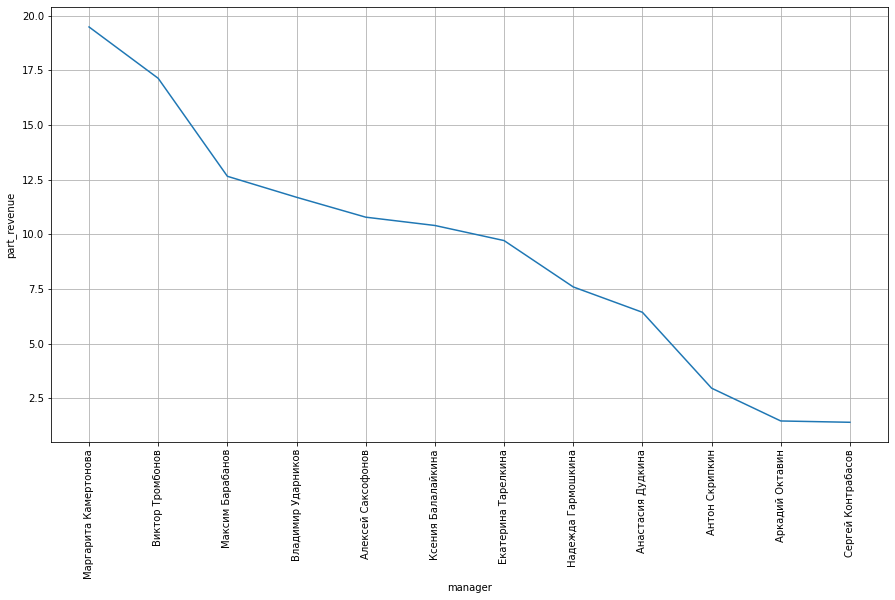

In [292]:
# Изобразим на графике прибыль по каждому менеджеру
fig, ax = plt.subplots(figsize=(15, 8))
ax = sns.lineplot(data=df_end, x= 'manager', y='part_revenue')
plt.grid() 
plt.xticks(rotation=90)
plt.show()

In [293]:
#устанавливаем размер всех графиков 
plt.rcParams["figure.figsize"] = [13, 7]         

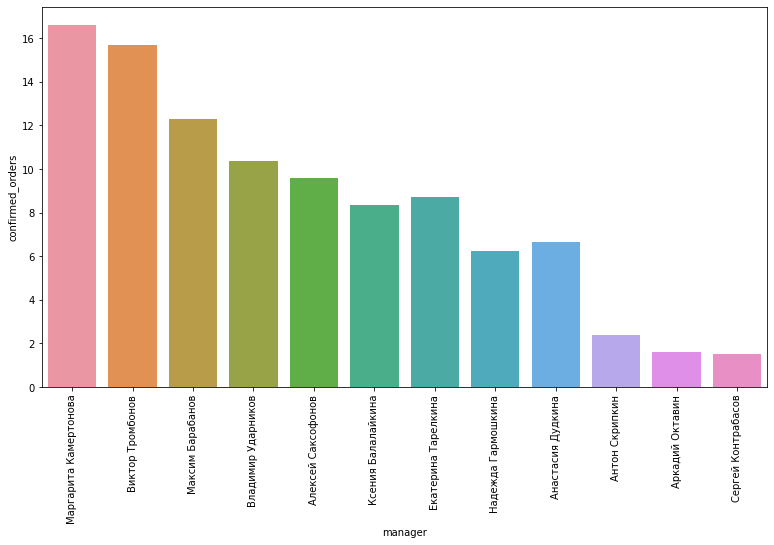

In [294]:
# Изобразим на графике количество заказов по каждому менеджеру
sns.barplot(x ='manager', y = 'confirmed_orders', data = df_end)
plt.xticks(rotation=90) 
plt.show()

#### Самыми эффективными менеджерами месяца оказались Маргарита Камертонова и Виктор Тромбонов, а самые плохие результаты показали Аркадий Октавин, Антон Скрипкин и Сергей Контрабасов.

## Итоги:

В данном проекте я проанализировала продажи музыкальных товаров: собрала данные, посчитала ключевые метрики в динамике; определила дни, которые выбиваются из общей картины, и выяснила причину этого; нашла наиболее прибыльные бренды и те, которые зря занимают место на виртуальной «полке».